In [86]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from scipy.io import loadmat

% matplotlib inline

## Filtering the real rod currents

In [91]:
x = loadmat('rodcurrents.mat')
Data = x['rodcurrents']
Data.shape

(350, 795)

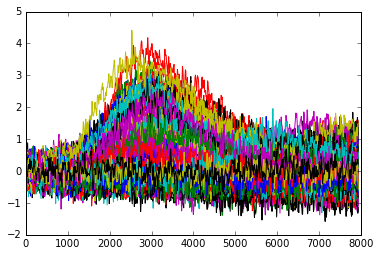

In [100]:
time = np.array(range(0,10*Data.shape[1],10))  #in ms
plt.plot(time,Data.T);

## Overdamped Broawnian motion

Particle in a potential well separated by barrier $V_0$ and located at $+/- x_0$. Drag or friction coefficient is $\gamma$ and the Langevin force is $\zeta$:

$$
\gamma \frac { d x ( t ) } { d t } = \frac { 4 V _ { 0 } } { x _ { 0 } } \left( \frac { x } { x _ { 0 } } \right) \left[ 1 - \left( \frac { x } { x _ { 0 } } \right) ^ { 2 } \right] + \zeta ( t )
$$


where at $k_B T$: 
$$
\left\langle \zeta ( t ) \zeta \left( t ^ { \prime } \right) \right\rangle = 2 \gamma k _ { B } T \delta \left( t - t ^ { \prime } \right)
$$

In [59]:
V0 = 10  #height of barrier
x0 = 5  #+/- minimum location
dt = 0.1  #time steps
T = 1000  #total time

Integrate the Langevin equation produces the term:

$$
z ( t ) = \int _ { t } ^ { t + \Delta t } d t \zeta ( t )
$$


In [60]:
zeta_t = np.random.randn(int(T/dt))
temp = 0
zt = np.array([temp + ii for ii in zeta_t])
print(np.var(zt))

1.0001204577378895


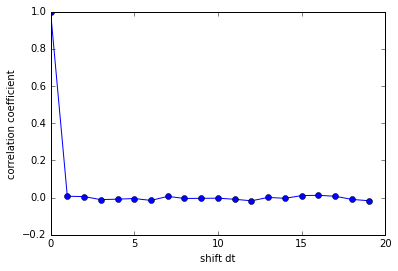

In [61]:
lag = 20
autocor = []
for l in range(0,lag):
    if l==0:
        temp = np.corrcoef(zt,zt)
    else:
        temp = np.corrcoef(zt[l:],zt[:-l])
    autocor.append(temp[0,1])
plt.plot(autocor,'-o')
plt.xlabel('shift dt')
plt.ylabel('correlation coefficient')

$$
\begin{aligned} \gamma \int _ { t } ^ { t + \Delta t } d t \frac { d x ( t ) } { d t } & = - \int _ { t } ^ { t + \Delta t } d t \frac { \partial V ( x ) } { \partial x } + \int _ { t } ^ { t + \Delta t } d t \zeta ( t ) \\ \gamma [ x ( t + \Delta t ) - x ( t ) ] & \approx - \Delta t \left. \frac { \partial V ( x ) } { \partial x } \right| _ { x = x ( t ) } + z ( t ) \end{aligned}
$$

Re-parameterize with $y = x / x _ { 0 }$ , parameter $\alpha = 4 k _ { B } T \Delta t / \left( \gamma x _ { 0 } ^ { 2 } \right)$, and energy $E ^ { \dagger } = V _ { 0 } / \left( k _ { B } T \right)$:

$$
y ( n + 1 ) = y ( n ) + \alpha E ^ { \dagger } \cdot y ( n ) \cdot \left[ 1 - y ^ { 2 } ( n ) \right] + \sqrt { \frac { \alpha } { 2 } } \xi ( n )
$$

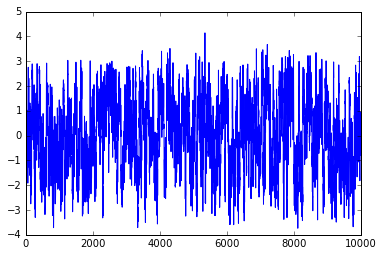

In [62]:
#test
gamma = 10
kBT = 300
alpha = 4*kBT*dt/(gamma*x0**2)
E_ = V0/kBT
y = np.zeros(int(T/dt))
for nn in range(0,len(y)-1):
    y[nn+1] = y[nn] + alpha*E_*y[nn]*(1-y[nn]**2) + np.sqrt(alpha/2)*zeta_t[nn]
plt.plot(y)

In [63]:
def y_SDE(alpha,E_,dt,T):
    '''
    Simulating SDE shown in the re-parameterized Langevin equation
    '''
    y = np.zeros(int(T/dt))
    for nn in range(0,len(y)-1):
        y[nn+1] = y[nn] + alpha*E_*y[nn]*(1-y[nn]**2) + np.sqrt(alpha/2)*zeta_t[nn]
    return y

For each value of $E^†$, check that your simulation runs long enough so that the distribution of $x$ actually is given by the Boltzmann distribution $P(x)\propto exp[−V(x)/k_BT]$. As $E^†$ increases,can you see that there are isolated discrete events corresponding to the chemical reaction in which the system jumps from one well to the other? Use your simulation to estimate the rate of these jumps, and plot the rate as a function of the activation energy $E^†$. Can you verify the Arrhenius law?

In [64]:
###Explore alpha values
Etemp = 0.01
alphas = np.linspace(0.1,5,10)
for aa in alphas:
    print('alpha=',aa,'variance of y=',np.var(y_SDE(aa,Etemp,dt,T)))
###->alpha should not be larger than 4.5-5 to produce stable finite time series

alpha= 0.1 variance of y= 3.5433814398015784
alpha= 0.6444444444444445 variance of y= 3.504960158314169
alpha= 1.188888888888889 variance of y= 3.5531677072063896
alpha= 1.7333333333333336 variance of y= 3.592400729430387
alpha= 2.277777777777778 variance of y= 3.6292748341808445
alpha= 2.8222222222222224 variance of y= 3.669563792841532
alpha= 3.366666666666667 variance of y= 3.734808135182746
alpha= 3.911111111111112 variance of y= 3.855172043616623
alpha= 4.455555555555556 variance of y= nan
alpha= 5.0 variance of y= nan


/Users/Macintosh/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in double_scalars
/Users/Macintosh/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in double_scalars


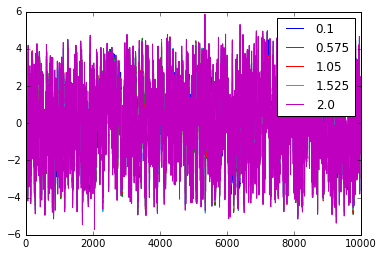

In [65]:
#visulization
Etemp = 0.01
alphas = np.linspace(0.1,2,5)
for aa in alphas:
    plt.plot(y_SDE(aa,Etemp,dt,T),label=aa)
    plt.hold(True)
plt.legend()

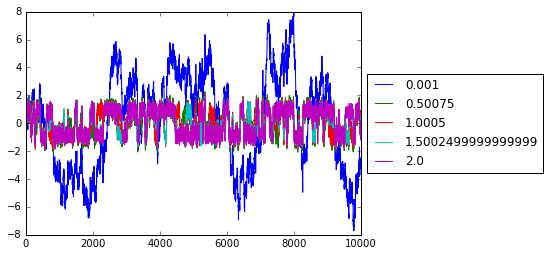

In [78]:
###Explore energy E'
Es = np.linspace(0.001,2,5)
alpha = 0.1
for EE in Es:
    plt.plot(y_SDE(alpha,EE,dt,T),label=EE)
    plt.hold(True)
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

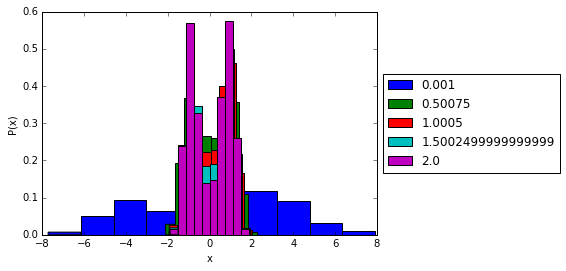

In [85]:
###Explore energy E'
Es = np.linspace(0.001,2,5)
alpha = 0.1
for EE in Es:
    plt.hist(y_SDE(alpha,EE,dt,T),label=str(EE),normed=True);
    plt.hold(True)
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('x')
plt.ylabel('P(x)')

In [102]:
def transiton_rate(x,threshold,dt):
    '''
    Input time series of x and the threshold that it should be crossing through time.
    The event of threshold/barrier crossing is detected and the rate of transition is estimated from dt steps
    '''
    sub = x - threshold
    temp = np.multiply(sub[1:],sub[:-1])
    cross = np.where(temp<0)[0]
    rate = 1/(np.diff(cross)*dt)
    return rate

In [133]:
est_r = []
threshold = 0
Es = np.linspace(0.001,5,20)
alpha = 0.1
for EE in Es:
    est_r.append(np.mean(transiton_rate(y_SDE(alpha,EE,dt,T),threshold,dt)))
    #est_r.append(transiton_rate(y_SDE(alpha,EE,dt,T),threshold,dt))

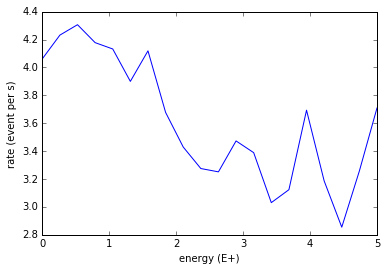

In [136]:
plt.plot(Es,est_r)
plt.xlabel('energy (E+)')
plt.ylabel('rate (event per s)')